# Event Classification with Deep Learning


We provide here an example on how deep neural networks can be used for identifying interesting events in High Energy Physics data analysis. 
The data orifinate from collisions at high-energy particle colliders and they can reveal exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification problems.  
Machine-learning approaches can be then extreamly useful for solving these problems. 

In this notebook we reproduce the results of the paper *Searching for Exotic Particles in High-Energy Physics with Deep Learning* by Baldi et al.,  presenting the successful usage of deep neural networks in high-energy particle physics applications.

The classification task is to distinguish between a signal process where new theoretical Higgs bosons (HIGGS) are produced, and a background process with the identical decay products but distinct kinematic features. 

Using the benchmark data set used in the paper we give an example on how to build first a shallow neural network with only one hidden layer  and then a deep neural network with 5 hidden layers and show that the superior classification results. 
One also can show that one cal rely only on low level features and still obtain very good classification performances. 


This example reproduces this important result with only about 100 lines of code using Keras. 
We aim to show all the working procedure: 
-  read input data
-  define the model
-  split input data in training, validation and test data sets
-  perform some simple preprocessing of the input
-  train (fit) the model to the training data and used validation for early stopping
-  test the trained model on an independet data set (the test data) to measure the performances


we start importing all the needed python modules. 
Wee will use Keras with the tensorflow implementation

In [1]:
import numpy as np
np.random.seed(1234)
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import subprocess
import h5py
import pickle

from keras.models import Sequential
from keras.layers import Dense, advanced_activations, Dropout
from keras import callbacks
from keras.optimizers import Adam
from keras.models import load_model


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Download the dataset

The full dataset has a size of about 1.2 GB. If you are using a mluserXX account you have access to a shared folder to read directly the file. 

Otherwise you can download from this [link](https://cernbox.cern.ch/index.php/s/ITX9KsIiqb2xs6M)

Uncomment the following lines if you want to use the full data set. 

In [2]:
# read full dataset file 
#file_ = h5py.File("/eos/user/m/moneta/ml-data/HIGGS_data.h5",'r')

#or download the file from https://cernbox.cern.ch/index.php/s/ITX9KsIiqb2xs6M

Otherwise we use as input a reduced data set containing 100k events that it is provided in the current directory. 
If using the full dataset, comment the following line, or do not execute the cell

In [3]:
file_ = h5py.File("HIGGS_data.h5",'r')

## Read the input data and the targets (labels)


The data consist of 28 input fetures of wich 21 low-level and 7 high-level variables. The variables describe kinematic properties of the event and they have different distributions between signal and background events. 
The low level features represent the basic measurements done by the particle detector such as the momentum of the observed particles.
The high level features consist instead of physically inspired derived quantities, such as invariant mass of the constituents, which reflect the production of intermediate states appearing when signal Higgs bosons are produced. 

The exact data descriptions are: 
* low level features (21): 
   * lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag
* high level features (7): 
   * m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb
   
For more detailed information about each feature see the original paper.



The data consists also of labels (targets) which are equal to 1 for signal events and 0 for background events. 


We want to reproduce the result of the paper using first all features (low + high level).

In [4]:
#file_ = h5py.File("HIGGS_data_small.h5")
inputs = np.array(file_["features"][:,:])
targets = np.array(file_["targets"])

In [5]:
#examine input data 
print("input data features (number of events, number of features) : ",inputs.shape)
print("Scan 5 input examples: ")
print(inputs[1:5])
print("Input labels (number of events, number of labels) ",targets.shape)
print(targets[1:5])

input data features (number of events, number of features) :  (100000, 28)
Scan 5 input examples: 
[[ 9.0754211e-01  3.2914728e-01  3.5941187e-01  1.4979699e+00
  -3.1300953e-01  1.0955306e+00 -5.5752492e-01 -1.5882298e+00
   2.1730762e+00  8.1258118e-01 -2.1364193e-01  1.2710146e+00
   2.2148721e+00  4.9999395e-01 -1.2614318e+00  7.3215616e-01
   0.0000000e+00  3.9870089e-01 -1.1389301e+00 -8.1911020e-04
   0.0000000e+00  3.0221990e-01  8.3304816e-01  9.8569965e-01
   9.7809839e-01  7.7973217e-01  9.9235576e-01  7.9834259e-01]
 [ 7.9883474e-01  1.4706388e+00 -1.6359748e+00  4.5377317e-01
   4.2562917e-01  1.1048746e+00  1.2823223e+00  1.3816643e+00
   0.0000000e+00  8.5173720e-01  1.5406590e+00 -8.1968951e-01
   2.2148721e+00  9.9348992e-01  3.5608011e-01 -2.0877755e-01
   2.5482244e+00  1.2569546e+00  1.1288476e+00  9.0046084e-01
   0.0000000e+00  9.0975326e-01  1.1083305e+00  9.8569220e-01
   9.5133126e-01  8.0325150e-01  8.6592442e-01  7.8011757e-01]
 [ 1.3443848e+00 -8.7662601e-01

### Examine some input features for the two classes

we plot now some of input features for both signal and background events. For doing this we create two separates arrays for the input features, one for the signal events (`sig_features`) and one for the background events (`bkg_features`) 

In [6]:
#separate features 
sfeatures = []
bfeatures = []
for i in range(inputs.shape[0]): 
    if (targets[i,0] == 1): 
       sfeatures.append(inputs[i,:])
    else:
       bfeatures.append(inputs[i,:])
        
sig_features = np.array(sfeatures)
bkg_features = np.array(bfeatures)
print('number of signal and background ',sig_features.shape[0],bkg_features.shape[0])

number of signal and background  52834 47166


As example we plot the lepton PT and lepton Eta for the low level features and two high level features, the bb and WWbb invariant masses. 
You can notice that the two samople have slightly different distributions

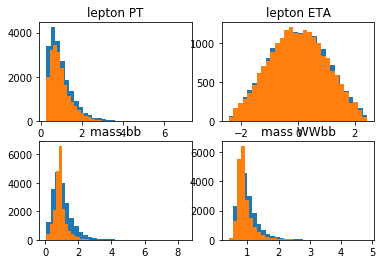

In [7]:
plt.figure(1)
plt.subplot(221)
n, bins, patches = plt.hist(bkg_features[:20000,0],30)
n, bins, patches = plt.hist(sig_features[:20000,0],30)
#n, bins, patches = plt.hist(inputs[:,0],30)
plt.title('lepton PT')
plt.subplot(222)
n, bins, patches = plt.hist(bkg_features[:20000,1],30)
n, bins, patches = plt.hist(sig_features[:20000,1],30)
#n, bins, patches = plt.hist(inputs[:,1],30)
plt.title('lepton ETA')
plt.subplot(223)
n, bins, patches = plt.hist(bkg_features[:20000,25],30)
n, bins, patches = plt.hist(sig_features[:20000,25],30)
plt.title('mass bb')
plt.subplot(224)
#n, bins, patches = plt.hist(inputs[:,27],30)
n, bins, patches = plt.hist(bkg_features[:20000,27],30)
n, bins, patches = plt.hist(sig_features[:20000,27],30)
plt.title('mass WWbb')
plt.show()

## Set up the models

We define now the neural network models. We create first a shallow neural network with a single hidden layer and then a deep neural network with 5 hidden layers.

#### Shallow network
  
we create a network with one hidden layer with 200 units and `tanh` activation function  

In [8]:
model_shallow = Sequential()
model_shallow.add(Dense(200, kernel_initializer="glorot_normal", activation="tanh", input_dim=inputs.shape[1]))
model_shallow.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model_shallow.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5800      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


We compile then model by defining the loss function and the type of optimizer we are going to use. 
In this case we use *Nadam*, the Nesterov Adam optimizer.
We specify also the type of loss function (`binary crossentropy`) and the training metric

In [9]:
model_shallow.compile( loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

### Deep network

We create a network with 5 hidden layers with 200 units and `RELU` activation functions 

In [10]:
model_deep = Sequential()

model_deep.add(Dense(200, kernel_initializer="glorot_normal", activation="relu" ,input_dim=inputs.shape[1]))
model_deep.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))

model_deep.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

model_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               5800      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 166,801
Trainable params: 166,801
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_deep.compile( loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

## Define training and test data

We split then the data in traiing and test data, using 20% for testing and the remaining 80% for training.
The splitting is random. 

In [12]:
# total number of events 
ntotal_evts = inputs.shape[0]

inputs_train, inputs_test, targets_train, targets_test = train_test_split(
                                            inputs, targets, test_size=0.20, random_state=1234 )

print ('splitting the total number of',ntotal_evts,
       'events in',inputs_train.shape[0],'train and',inputs_test.shape[0],'test events')

splitting the total number of 100000 events in 80000 train and 20000 test events


## Prepare pre-processing

As preprocessing, we use a standard scaler provided by the `sklearn` package. This preprocessing method takes each input and subtracts the mean and then divides by the standard-deviation so that the final distribution is centered around 0 with a width of 1.

In [13]:
preprocessing_input = StandardScaler()
preprocessing_input.fit(inputs_train)
pickle.dump(preprocessing_input, open("HIGGS_preprocessing.pickle", "wb"))

For example we plot the leptonPT and m_bb invariant mass after pre-processing

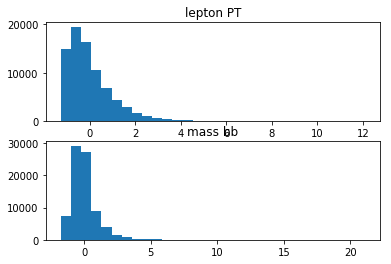

In [14]:
preprocessed_input  = preprocessing_input.transform(inputs_train)
plt.figure(1)
plt.subplot(211)
n, bins, patches = plt.hist(preprocessed_input[:,0],30)
plt.title('lepton PT')
plt.subplot(212)
n, bins, patches = plt.hist(preprocessed_input[:,25],30)
plt.title('mass bb')
plt.show()

## Model Training

The following code trains the neural network model.
During training we use 25% of the data for the validation and 75% for the actual training.
The validation data is used to compute the loss function and use it for early stopping and for saving the best 
model weights. 
When the validation loss function does not decreare after s certain number of epochs (i.e. a full data iteration) the trainig will stop. We save also the model weights for the best value optained of the validation loss. 

Other parameters we can define are the batch size (e.g. 512) and the maximum number of epochs (e.g. 50)
At the end we save the model in case we need to reuse later for predictions


In [15]:
early_stopper = callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto")
model_check_point = callbacks.ModelCheckpoint("model_shallow.h5", monitor = 'val_loss', verbose=True, 
                                              save_best_only=True, mode='auto')

    
print("Train now the shallow model ")
    
history_s = model_shallow.fit(
                preprocessing_input.transform(inputs_train),
                targets_train,
                batch_size=512,
                epochs=20,
                validation_split=0.25,
                callbacks=[early_stopper, model_check_point] )


Train now the shallow model 
Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.6466 - acc: 0.6220 - val_loss: 0.6406 - val_acc: 0.6287

Epoch 00001: val_loss improved from inf to 0.64055, saving model to model_shallow.h5
Epoch 2/20
60000/60000 [==============================] - 0s 6us/step - loss: 0.6368 - acc: 0.6400 - val_loss: 0.6337 - val_acc: 0.6425

Epoch 00002: val_loss improved from 0.64055 to 0.63370, saving model to model_shallow.h5
Epoch 3/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.6318 - acc: 0.6454 - val_loss: 0.6321 - val_acc: 0.6410

Epoch 00003: val_loss improved from 0.63370 to 0.63211, saving model to model_shallow.h5
Epoch 4/20
60000/60000 [==============================] - 0s 4us/step - loss: 0.6263 - acc: 0.6519 - val_loss: 0.6322 - val_acc: 0.6424

Epoch 00004: val_loss did not improve from 0.63211
Epoch 5/20
60000/60000 [==============================] - 

We can plot the obtained values of the training and validation loss function

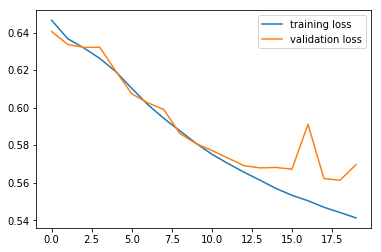

In [16]:
plt.plot(history_s.history["loss"], label="training loss")
plt.plot(history_s.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

### Train  the Deep model

We repeat the training now, using the same parameters for the deep model. 
Being the model more complex, it will take longer...

If you have a GPU in your computer, here, you can experience quickly why deep-learning is heavily dependent on GPUs to speed up the training!

In [17]:
print("Train now the deep model ")


early_stopper = callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto", verbose=True)
model_check_point = callbacks.ModelCheckpoint("model_deep.h5", monitor = 'val_loss', verbose=True, 
                                              save_best_only=True, mode='auto')


history_d = model_deep.fit(
                preprocessing_input.transform(inputs_train),
                targets_train,
                batch_size=512,
                epochs=20,
                validation_split=0.25,
                callbacks=[early_stopper, model_check_point] )


Train now the deep model 
Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.6285 - acc: 0.6409 - val_loss: 0.6126 - val_acc: 0.6555

Epoch 00001: val_loss improved from inf to 0.61257, saving model to model_deep.h5
Epoch 2/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.5820 - acc: 0.6936 - val_loss: 0.6089 - val_acc: 0.6708

Epoch 00002: val_loss improved from 0.61257 to 0.60887, saving model to model_deep.h5
Epoch 3/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.5608 - acc: 0.7096 - val_loss: 0.5690 - val_acc: 0.6969

Epoch 00003: val_loss improved from 0.60887 to 0.56897, saving model to model_deep.h5
Epoch 4/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.5447 - acc: 0.7220 - val_loss: 0.5574 - val_acc: 0.7053

Epoch 00004: val_loss improved from 0.56897 to 0.55736, saving model to model_deep.h5
Epoch 5/20
60000/60000 [===========

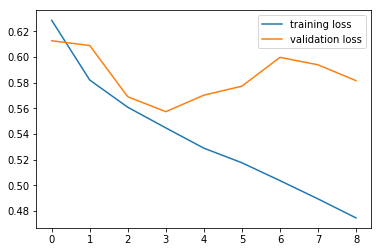

In [18]:
plt.plot(history_d.history["loss"], label="training loss")
plt.plot(history_d.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

## Test the models

Now we want to test the trained models on the indipendent test data set, which we have previously defined, and we measure the model  classification performances. 

We load the model best weights (saved previously in a file) and the pre-processing parameters


In [19]:
model_shallow = load_model("model_shallow.h5")
model_deep = load_model("model_deep.h5")
preprocessing_input = pickle.load(open("HIGGS_preprocessing.pickle", "rb"))

### Model prediction using the test data 

Here we peform the model prediction on the test data set 

In [20]:
print('testing models using',inputs_test.shape[0],'events')

ntest_evts = inputs_test.shape[0]
#in case we want to use a smaller set of test data 
#num_events = 200000
predictions_shallow = model_shallow.predict(
        preprocessing_input.transform(inputs_test[:ntest_evts]))
predictions_deep = model_deep.predict(
        preprocessing_input.transform(inputs_test[:ntest_evts]))

testing models using 20000 events


### Compute ROC curve and AUC

We measure the model classification performances by calculating the AUC (Area Under the ROC curve)

In [21]:
fpr_shallow, tpr_shallow, _ = roc_curve(targets_test[:ntest_evts], predictions_shallow)
fpr_deep, tpr_deep, _ = roc_curve(targets_test[:ntest_evts], predictions_deep)

auc_shallow = auc(fpr_shallow, tpr_shallow)
auc_deep = auc(fpr_deep, tpr_deep)

print("AUC shallow model = ",auc_shallow)
print("AUC  deep model   = ",auc_deep)

AUC shallow model =  0.7720126051725067
AUC  deep model   =  0.7851046606156611


### Plot Result 

We plot also the resulting ROC curve for the model we have tested

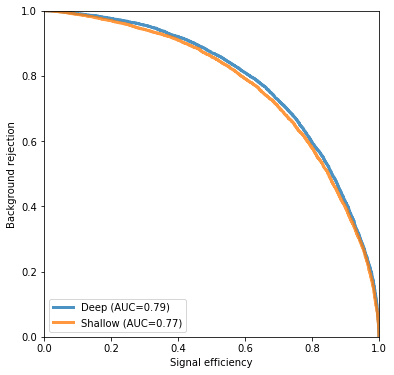

In [22]:
plt.figure(figsize=(6,6))
plt.plot(tpr_deep, 1.0-fpr_deep, lw=3, alpha=0.8,
        label="Deep (AUC={:.2f})".format(auc_deep))
plt.plot(tpr_shallow, 1.0-fpr_shallow, lw=3, alpha=0.8,
        label="Shallow (AUC={:.2f})".format(auc_shallow))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.legend(loc=3)
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.savefig("HIGGS_roc.png", bbox_inches="tight")